## Full Annotated KAN Network Implementation and Examples Following https://alexzhang13.github.io/blog/2024/annotated-kan

In [ ]:
# Run if in Colab, otherwise run pip install in virtual env
!pip install torch==2.3.1
!pip install numpy==1.26.4
!pip install matplotlib==3.9.0
!pip install tqdm==4.66.4
!pip install torchvision==0.18.1

In [2]:
# Python libraries
import os
from typing import List, Dict, Optional, Self
import random
import warnings

# Installed libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Part I & III: KAN Module with B-Spline Optimizations
We first define the high-level KAN module and its associated parameters as a config struct. In a more fleshed out codebase, we can replace this with a config file or add methods for it.

In [3]:
class KANConfig:
    """
    Configuration struct to define a standard KAN.
    """

    residual_std = 0.1
    grid_size = 5
    spline_order = 3
    grid_range = [-1.0, 1.0]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class KAN(nn.Module):
    """
    Standard architecture for Kolmogorov-Arnold Networks described in the original paper.
    Layers are defined via a list of layer widths.
    """

    def __init__(
        self,
        layer_widths: List[int],
        config: KANConfig,
    ):
        super(KAN, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layer_widths = layer_widths
        self.config = config

        in_widths = layer_widths[:-1]
        out_widths = layer_widths[1:]

        for in_dim, out_dim in zip(in_widths, out_widths):
            self.layers.append(
                KANLayer(
                    in_dim=in_dim,
                    out_dim=out_dim,
                    grid_size=config.grid_size,
                    spline_order=config.spline_order,
                    device=config.device,
                    residual_std=config.residual_std,
                    grid_range=config.grid_range,
                )
            )

    def forward(self, x: torch.Tensor):
        """
        Standard forward pass sequentially across each layer.
        """
        for layer in self.layers:
            x = layer(x)

        return x

    @torch.no_grad
    def set_symbolic(
        self,
        layer: int,
        in_index: int,
        out_index: int,
        fix: bool,
        fn,
    ):
        """
        For layer {layer}, activation {in_index, out_index}, fix (or unfix if {fix=False})
        the output to the function {fn}. This is grossly inefficient, but works.
        """
        self.layers[layer].set_symbolic(in_index, out_index, fix, fn)

    @torch.no_grad
    def prune(self, x: torch.Tensor, mag_threshold: float = 0.01):
        """
        Prune (mask) a node in a KAN layer if the normalized activation
        incoming or outgoing are lower than mag_threshold.
        """
        # Collect activations and cache
        self.forward(x)

        # Can't prune at last layer
        for l_idx in range(len(self.layers) - 1):
            # Average over the batch and take the abs of all edges
            in_mags = torch.abs(torch.mean(self.layers[l_idx].activations, dim=0))

            # (in_dim, out_dim), average over out_dim
            in_score = torch.max(in_mags, dim=-1)[0]

            # Average over the batch and take the abs of all edges
            out_mags = torch.abs(torch.mean(self.layers[l_idx + 1].activations, dim=0))

            # (in_dim, out_dim), average over out_dim
            out_score = torch.max(out_mags, dim=0)[0]

            # Check for input, output (normalized) activations > mag_threshold
            active_neurons = (in_score > mag_threshold) * (out_score > mag_threshold)
            inactive_neurons_indices = (active_neurons == 0).nonzero()

            # Mask all relevant activations
            self.layers[l_idx + 1].activation_mask[:, inactive_neurons_indices] = 0
            self.layers[l_idx].activation_mask[inactive_neurons_indices, :] = 0

    @torch.no_grad
    def grid_extension(self, x: torch.Tensor, new_grid_size: int):
        """
        Increase granularity of B-spline by changing the grid size
        in the B-spline computation to be new_grid_size.
        """
        self.forward(x)
        for l_idx in range(len(self.layers)):
            self.layers[l_idx].grid_extension(self.layers[l_idx].inp, new_grid_size)
        self.config.grid_size = new_grid_size

In [5]:
class WeightedResidualLayer(nn.Module):
    """
    Defines the activation function used in the paper,
    phi(x) = w_b SiLU(x) + w_s B_spline(x)
    as a layer.
    """

    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        residual_std: float = 0.1,
    ):
        super(WeightedResidualLayer, self).__init__()
        self.univariate_weight = torch.nn.Parameter(
            torch.Tensor(out_dim, in_dim)
        )  # w_s in paper

        # Residual activation functions
        self.residual_fn = F.silu
        self.residual_weight = torch.nn.Parameter(
            torch.Tensor(out_dim, in_dim)
        )  # w_b in paper

        self._initialization(residual_std)


    def _initialization(self, residual_std):
        """
        Initialize each parameter according to the original paper.
        """
        nn.init.normal_(self.residual_weight, mean=0.0, std=residual_std)
        nn.init.ones_(self.univariate_weight)

    def forward(self, x: torch.Tensor, post_acts: torch.Tensor):
        """
        Given the input to a KAN layer and the activation (e.g. spline(x)),
        compute a weighted residual.
        
        x has shape (bsz, in_dim) and act has shape (bsz, out_dim, in_dim)
        """

        # Broadcast the input along out_dim of post_acts
        res = self.residual_weight * self.residual_fn(x[:, None, :])
        act = self.univariate_weight * post_acts
        return res + act

In [6]:
class KANSymbolic(nn.Module):
    "Defines and stores the Symbolic functions fixed / set for a KAN."

    def __init__(self, in_dim: int, out_dim: int, device: torch.device):
        """
        We have to store a 2D array of univariate functions, one for each
        edge in the KAN layer. 
        """
        super(KANSymbolic, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.fns = [[lambda x: x for _ in range(in_dim)] for _ in range(out_dim)]
    
    def forward(self, x: torch.Tensor):
        """
        Run symbolic activations over all inputs in x, where
        x is of shape (batch_size, in_dim). Returns a tensor of shape
        (batch_size, out_dim, in_dim).
        """
        
        acts = []
        # Really inefficient, try tensorizing later.
        for j in range(self.in_dim):
            act_ins = []
            for i in range(self.out_dim):
                o = torch.vmap(self.fns[i][j])(x[:,[j]]).squeeze(dim=-1)
                act_ins.append(o)
            acts.append(torch.stack(act_ins, dim=-1))
        acts = torch.stack(acts, dim=-1)

        return acts

    def set_symbolic(self, in_index: int, out_index: int, fn):
        """
        Set symbolic function at specified edge to new function.
        """
        self.fns[out_index][in_index] = fn 

In [7]:
class KANLayer(nn.Module):
    "Defines a KAN layer from in_dim variables to out_dim variables."

    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        grid_size: int,
        spline_order: int,
        device: torch.device,
        residual_std: float = 0.1,
        grid_range: List[float] = [-1, 1],
    ):
        super(KANLayer, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.grid_size = grid_size
        self.spline_order = spline_order
        self.device = device

        # Define univariate function (splines in original KAN)
        self.activation_fn = KANActivation(
            in_dim,
            out_dim,
            spline_order,
            grid_size,
            device,
            grid_range,
        )
        
        self.symbolic_fn = KANSymbolic(
            in_dim,
            out_dim,
            device
        )

        self.activation_mask = nn.Parameter(
            torch.ones((out_dim, in_dim), device=device)
        ).requires_grad_(False)
        self.symbolic_mask = torch.nn.Parameter(torch.zeros(out_dim, in_dim, device=device)).requires_grad_(False)

        # Define the residual connection layer used to compute \phi
        self.residual_layer = WeightedResidualLayer(in_dim, out_dim, residual_std)

        # Cache for regularization
        self.inp = torch.empty(0)
        self.activations = torch.empty(0)

    def cache(self, inp: torch.Tensor, acts: torch.Tensor):
        self.inp = inp
        self.activations = acts

    def set_symbolic(self, in_index: int, out_index: int, fix:bool, fn):
        """
        Set the symbolic mask to be fixed (fix=1) or unfixed. 
        """
        if fix:
            self.symbolic_mask[out_index, in_index] = 1
            self.symbolic_fn.set_symbolic(in_index, out_index, fn)
        else:
            self.symbolic_mask[out_index, in_index] = 0


    def forward(self, x: torch.Tensor):
        """
        Forward pass of KAN. x is expected to be of shape (batch_size, input_size)
        where input_size is the number of input scalars.

        Stores the activations needed for computing the L1 regularization and
        entropy regularization terms.

        Returns the output of the KAN operation.
        """

        spline = self.activation_fn(x)

        # Form the batch of matrices phi(x) of shape [batch_size x out_dim x in_dim]
        phi = self.residual_layer(x, spline)

        # Perform symbolic computations
        sym_phi = self.symbolic_fn(x)
        phi = phi * (self.symbolic_mask == 0) + sym_phi * self.symbolic_mask

        # Mask out pruned edges
        phi = phi * self.activation_mask[None, ...]

        # Cache activations for regularization during training.
        # Also useful for visualizing. Can remove for inference.
        self.cache(x, phi)

        # Really inefficient matmul
        out = torch.sum(phi, dim=-1)

        return out

    def grid_extension(self, x: torch.Tensor, new_grid_size: int):
        """
        Increase granularity of B-spline by increasing the
        number of grid points while maintaining the spline shape.
        """

        self.grid_size = new_grid_size
        self.activation_fn.grid_extension(x, new_grid_size)

In [8]:
def generate_control_points(
    low_bound: float,
    up_bound: float,
    in_dim: int,
    out_dim: int,
    spline_order: int,
    grid_size: int,
    device: torch.device,
):
    """
    Generate a vector of {grid_size} equally spaced points in the interval 
    [low_bound, up_bound] and broadcast (out_dim, in_dim) copies.
    To account for B-splines of order k, using the same spacing, generate an additional
    k points on each side of the interval. See 2.4 in original paper for details.
    """

    # vector of size [grid_size + 2 * spline_order + 1] 
    spacing = (up_bound - low_bound) / grid_size
    grid = torch.arange(-spline_order, grid_size + spline_order + 1, device=device)
    grid = grid * spacing + low_bound

    # [out_dim, in_dim, G + 2k + 1]
    grid = grid[None, None, ...].expand(out_dim, in_dim, -1).contiguous()
    return grid

In [9]:
# Helper functions for computing B splines over a grid
def compute_bspline(x: torch.Tensor, grid: torch.Tensor, k: int, device: torch.device):
    """
    For a given grid with G_1 intervals and spline order k, we *recursively* compute
    and evaluate each B_n(x_{ij}). x is a (batch_size, in_dim) and grid is a
    (out_dim, in_dim, # grid points + 2k + 1)

    Returns a (batch_size, out_dim, in_dim, grid_size + k) intermediate tensor to 
    compute sum_i {c_i B_i(x)} with.

    """
    
    grid = grid[None, :, :, :].to(device)
    x = x[:, None, :, None].to(device)
    
    # Base case: B_{i,0}(x) = 1 if (grid_i <= x <= grid_{i+k}) 0 otherwise
    bases = (x >= grid[:, :, :, :-1]) * (x < grid[:, :, :, 1:])

    # Recurse over spline order j, vectorize over basis function i
    for j in range (1, k + 1):
        n = grid.size(-1) - (j + 1)
        b1 = ((x[:, :, :, :] - grid[:, :, :, :n]) / (grid[:, :, :, j:-1] - grid[:, :, :, :n])) 
        b1 = b1 * bases[:, :, :, :-1]
        b2 = ((grid[:, :, :, j+1:] - x[:, :, :, :])  / (grid[:, :, :, j+1:] - grid[:, :, :, 1:n+1])) 
        b2 = b2 * bases[:, :, :, 1:]
        bases = b1 + b2

    return bases

In [10]:
class KANActivation(nn.Module):
    """
    Defines a KAN Activation layer that computes the spline(x) logic
    described in the original paper.
    """

    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        spline_order: int,
        grid_size: int,
        device: torch.device,
        grid_range: List[float],
    ):
        super(KANActivation, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.spline_order = spline_order
        self.grid_size = grid_size
        self.device = device
        self.grid_range = grid_range
        # Generate (out, in) copies of equally spaced control points on [a, b]
        grid = generate_control_points(
            grid_range[0],
            grid_range[1],
            in_dim,
            out_dim,
            spline_order,
            grid_size,
            device,
        )
        self.register_buffer("grid", grid)

        # Define the univariate B-spline function
        self.univarate_fn = compute_bspline

        # Spline parameters
        self.coef = torch.nn.Parameter(
            torch.Tensor(out_dim, in_dim, grid_size + spline_order)
        )

        self._initialization()

    def _initialization(self):
        """
        Initialize each parameter according to the original paper.
        """
        nn.init.xavier_normal_(self.coef)

    def forward(self, x: torch.Tensor):
        """
        Compute and evaluate the learnable activation functions
        applied to a batch of inputs of size in_dim each.
        """
        # [bsz x in_dim] to [bsz x out_dim x in_dim x (grid_size + spline_order)]
        bases = self.univarate_fn(x, self.grid, self.spline_order, self.device)

        # [bsz x out_dim x in_dim x (grid_size + spline_order)]
        postacts = bases * self.coef[None, ...]

        # [bsz x out_dim x in_dim] to [bsz x out_dim]
        spline = torch.sum(postacts, dim=-1)

        return spline

    def grid_extension(self, x: torch.Tensor, new_grid_size: int):
        """
        Increase granularity of B-spline activation by increasing the
        number of grid points while maintaining the spline shape.
        """

        # Re-generate grid points with extended size (uniform)
        new_grid = generate_control_points(
            self.grid_range[0],
            self.grid_range[1],
            self.in_dim,
            self.out_dim,
            self.spline_order,
            new_grid_size,
            self.device,
        )

        # bsz x out_dim x in_dim x (old_grid_size + spline_order)
        old_bases = self.univarate_fn(x, self.grid, self.spline_order, self.device)

        # bsz x out_dim x in_dim x (new_grid_size + spline_order)
        bases = self.univarate_fn(x, new_grid, self.spline_order, self.device)
        # out_dim x in_dim x bsz x (new_grid_size + spline_order)
        bases = bases.permute(1, 2, 0, 3)

        # bsz x out_dim x in_dim
        postacts = torch.sum(old_bases * self.coef[None, ...], dim=-1)
        # out_dim x in_dim x bsz
        postacts = postacts.permute(1, 2, 0)

        # solve for X in AX = B, A is bases and B is postacts
        new_coefs = torch.linalg.lstsq(
            bases.to(self.device),
            postacts.to(self.device),
            driver="gelsy" if self.device == "cpu" else "gelsd",
        ).solution

        # Set new parameters
        self.grid_size = new_grid_size
        self.grid = new_grid
        self.coef = torch.nn.Parameter(new_coefs, requires_grad=True)

In [11]:
def l1_regularization(model: KAN):
    """
    Compute L1 regularization of activations by using
    cached activations. Must be called after KAN forward pass
    during training.
    """
    reg = torch.tensor(0.)
    # regularize coefficient to encourage spline to be zero
    for i in range(len(model.layers)):
        acts = model.layers[i].activations
        l1_activations = torch.sum(torch.mean(torch.abs(acts), dim=0))
        reg += l1_activations

    return reg

In [12]:
def entropy_regularization(model: KAN):
    """
    Compute entropy regularization of activations by using
    cached activations. Must be called after KAN forward pass
    during training.
    """
    reg = torch.tensor(0.)
    eps = 1e-4
    # regularize coefficient to encourage spline to be zero
    for i in range(len(model.layers)):
        acts = model.layers[i].activations
        l1_activations = torch.sum(torch.mean(torch.abs(acts), dim=0))
        activations = (
            torch.mean(torch.abs(l1_activations), dim=0)
            / l1_activations
        )
        entropy = -torch.sum(activations * torch.log(activations + eps))
        reg += entropy

    return reg

In [13]:
def regularization(
    model: KAN,
    l1_factor: float = 1,
    entropy_factor: float = 1,
):
    """
    Regularization described in the original KAN paper. Involves an L1
    and an entropy factor.
    """
    return l1_factor * l1_regularization(model) + \
    entropy_factor * entropy_regularization(model)

## Part II: KAN Training
We define the corresponding dataset and training loop.

In [14]:
# Helper function derived from https://github.com/KindXiaoming/pykan/blob/master/kan/utils.py
def create_dataset(
    f,
    n_var: int=2,
    ranges=[-1, 1],
    train_num: int =1000,
    test_num: int=1000,
    device: torch.device = torch.device("cpu"),
    seed: int=0,
):
    """
    Create a synthetic dataset as a function of n_var variables
    """
    def normalize(data, mean, std):
      return (data - mean) / std

    np.random.seed(seed)
    torch.manual_seed(seed)

    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var, 2)
    else:
        ranges = np.array(ranges)

    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)
    for i in range(n_var):
        train_input[:, i] = (
            torch.rand(
                train_num,
            )
            * (ranges[i, 1] - ranges[i, 0])
            + ranges[i, 0]
        )
        test_input[:, i] = (
            torch.rand(
                test_num,
            )
            * (ranges[i, 1] - ranges[i, 0])
            + ranges[i, 0]
        )

    train_label = f(train_input)
    test_label = f(test_input)

    mean_input = torch.mean(train_input, dim=0, keepdim=True)
    std_input = torch.std(train_input, dim=0, keepdim=True)
    train_input = normalize(train_input, mean_input, std_input)
    test_input = normalize(test_input, mean_input, std_input)

    mean_label = torch.mean(train_label, dim=0, keepdim=True)
    std_label = torch.std(train_label, dim=0, keepdim=True)
    train_label = normalize(train_label, mean_label, std_label)
    test_label = normalize(test_label, mean_label, std_label)

    dataset = {}
    dataset["train_input"] = train_input.to(device)
    dataset["test_input"] = test_input.to(device)

    dataset["train_label"] = train_label.to(device)
    dataset["test_label"] = test_label.to(device)

    return dataset

In [15]:
# Adapted from https://github.com/KindXiaoming/pykan
def train(
    model: KAN,
    dataset: Dict[str, torch.Tensor],
    batch_size: int,
    batch_size_test: int,
    device: torch.device,
    reg_lambda: float = 0.1,
    steps: int = 10000,
    loss_fn=None,
    loss_fn_eval=None,
    log: int = 20,
    lr: float = 3e-5,
    save_path: str ='./saved_models/',
    ckpt_name: Optional[str] = 'best.pt',
):
    """
    Train loop for KANs. Logs loss every {log} steps and uses
    the best checkpoint as the trained model. Returns a dict of
    the loss trajectory.
    """
    if not os.path.exists(save_path):
       os.makedirs(save_path) 

    pbar = tqdm(range(steps), desc="KAN Training", ncols=200)

    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)
    if loss_fn_eval is None:
        loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    results = {}
    results["train_loss"] = []
    results["test_loss"] = []
    results["regularization"] = []
    results["best_test_loss"] = []

    train_size = dataset["train_input"].shape[0]
    test_size = dataset["test_input"].shape[0]

    best_test_loss = torch.tensor(1e9)

    for step in pbar:
        train_id = np.random.choice(train_size, batch_size, replace=False)
        test_id = np.random.choice(test_size, batch_size_test, replace=False)
        x = dataset["train_input"][train_id].to(device)
        y = dataset["train_label"][train_id].to(device)
        x_eval = dataset["test_input"][test_id].to(device)
        y_eval = dataset["test_label"][test_id].to(device)

        pred = model.forward(x)
        train_loss = loss_fn(pred, y)
        ent_l1_reg = regularization(model)
        loss = train_loss + reg_lambda * ent_l1_reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        test_loss = loss_fn_eval(model.forward(x_eval), y_eval)
        if best_test_loss > test_loss:
            best_test_loss = test_loss
            if ckpt_name is not None:
                torch.save(model.state_dict(), os.path.join(save_path, ckpt_name))

        if step % log == 0:
            pbar.set_description(
                "train loss: %.2e | test loss: %.2e | reg: %.2e "
                % (
                    train_loss.cpu().detach().numpy(),
                    test_loss.cpu().detach().numpy(),
                    ent_l1_reg.cpu().detach().numpy(),
                )
            )

        results["train_loss"].append(train_loss.cpu().detach().numpy())
        results["test_loss"].append(test_loss.cpu().detach().numpy())
        results["best_test_loss"].append(best_test_loss.cpu().detach().numpy())
        results["regularization"].append(ent_l1_reg.cpu().detach().numpy())

    if ckpt_name is not None:
        model.load_state_dict(torch.load(os.path.join(save_path, ckpt_name)))

    return results

In [16]:
def plot_results(results: Dict[str, List[float]]):
    """
    Function for plotting the interior of a KAN, similar to the original paper.
    """
    for key, value in results.items():
        plt.plot(value)
        plt.title(key)
        plt.show()

In [17]:
def plot(model: KAN, folder="./figures", scale=0.5, title=None):
    """
    Function for plotting KANs and visualizing their activations adapted from
    https://github.com/KindXiaoming/pykan/blob/master/kan/KAN.py#L561
    """
    if not os.path.exists(folder):
        os.makedirs(folder)

    depth = len(model.layer_widths) - 1
    for l in range(depth):
        w_large = 2.0
        for i in range(model.layer_widths[l]):
            for j in range(model.layer_widths[l + 1]):
                rank = torch.argsort(model.layers[l].inp[:, i])
                fig, ax = plt.subplots(figsize=(w_large, w_large))
                plt.gca().patch.set_edgecolor("white")
                plt.gca().patch.set_linewidth(1.5)

                color = "black"
                plt.plot(
                    model.layers[l].inp[:, i][rank].cpu().detach().numpy(),
                    model.layers[l].activations[:, j, i][rank].cpu().detach().numpy(),
                    color=color,
                    lw=5,
                )
                plt.gca().spines[:].set_color(color)
                plt.savefig(
                    f"{folder}/sp_{l}_{i}_{j}.png", bbox_inches="tight", dpi=400
                )
                plt.close()

    # draw skeleton
    width = np.array(model.layer_widths)
    A = 1
    y0 = 0.4

    neuron_depth = len(width)
    min_spacing = A / np.maximum(np.max(width), 5)

    max_num_weights = np.max(width[:-1] * width[1:])
    y1 = 0.4 / np.maximum(max_num_weights, 3)

    fig, ax = plt.subplots(figsize=(10 * scale, 10 * scale * (neuron_depth - 1) * y0))

    # plot scatters and lines
    for l in range(neuron_depth):
        n = width[l]
        for i in range(n):
            plt.scatter(
                1 / (2 * n) + i / n,
                l * y0,
                s=min_spacing**2 * 10000 * scale**2,
                color="black",
            )

            if l < neuron_depth - 1:
                # plot connections
                n_next = width[l + 1]
                N = n * n_next
                for j in range(n_next):
                    id_ = i * n_next + j
                    color = "black"
                    plt.plot(
                        [1 / (2 * n) + i / n, 1 / (2 * N) + id_ / N],
                        [l * y0, (l + 1 / 2) * y0 - y1],
                        color=color,
                        lw=2 * scale,
                    )
                    plt.plot(
                        [1 / (2 * N) + id_ / N, 1 / (2 * n_next) + j / n_next],
                        [(l + 1 / 2) * y0 + y1, (l + 1) * y0],
                        color=color,
                        lw=2 * scale,
                    )

        plt.xlim(0, 1)
        plt.ylim(-0.1 * y0, (neuron_depth - 1 + 0.1) * y0)

    # -- Transformation functions
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # -- Take data coordinates and transform them to normalized figure coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

    plt.axis("off")

    # plot splines
    for l in range(neuron_depth - 1):
        n = width[l]
        for i in range(n):
            n_next = width[l + 1]
            N = n * n_next
            for j in range(n_next):
                id_ = i * n_next + j
                im = plt.imread(f"{folder}/sp_{l}_{i}_{j}.png")
                left = DC_to_NFC([1 / (2 * N) + id_ / N - y1, 0])[0]
                right = DC_to_NFC([1 / (2 * N) + id_ / N + y1, 0])[0]
                bottom = DC_to_NFC([0, (l + 1 / 2) * y0 - y1])[1]
                up = DC_to_NFC([0, (l + 1 / 2) * y0 + y1])[1]
                newax = fig.add_axes((left, bottom, right - left, up - bottom))
                newax.imshow(im)
                newax.axis("off")

    if title is not None:
        plt.title(title)

    plt.show()

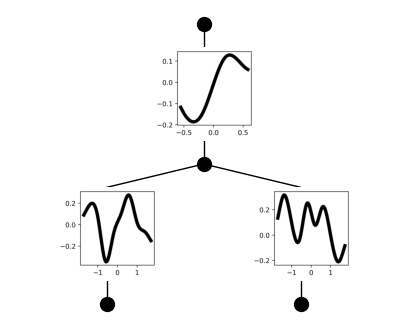

In [18]:
f = lambda x: (torch.sin(x[:, [0]]) + x[:, [1]] ** 2)
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=100)

# Initialize and plot KAN
config = KANConfig()
layer_widths = [2, 1, 1]
model = KAN(layer_widths, config)
model(dataset["train_input"])
plot(model)

In [19]:
seed = 7
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]] ** 3)
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=100)

config = KANConfig()
layer_widths = [2, 1, 1]
model = KAN(layer_widths, config)

results = train(
    model,
    dataset=dataset,
    steps=50000,
    batch_size=128,
    batch_size_test=32,
    lr=0.01,
    device=config.device,
)

train loss: 5.34e-03 | test loss: 5.53e-03 | reg: 8.30e-01 : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:19<00:00, 631.76it/s]


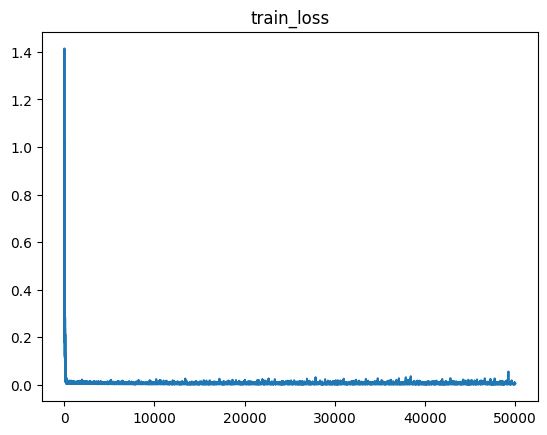

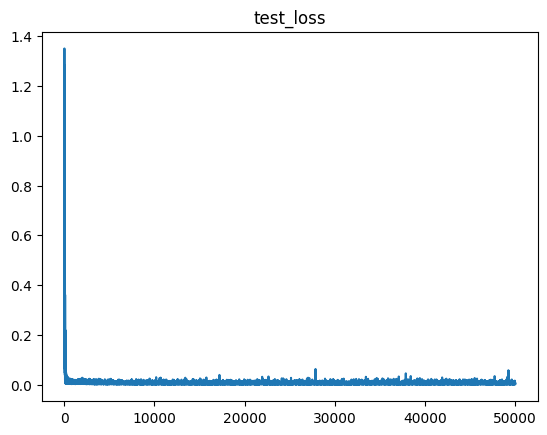

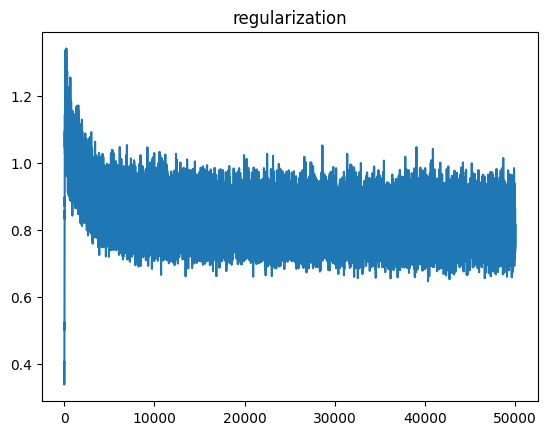

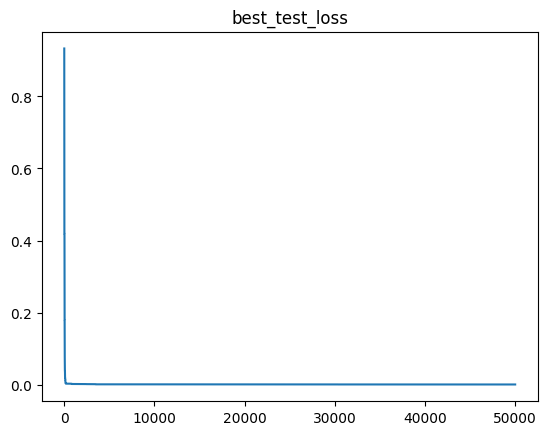

In [20]:
plot_results(results)

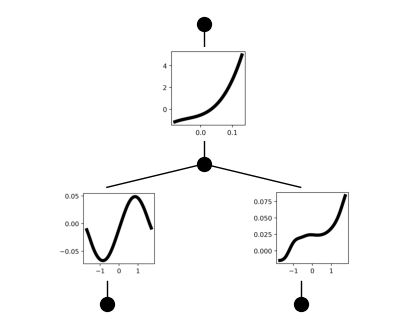

In [21]:
# Plot network activations
model(dataset["train_input"])
plot(model)

## Symbolic Activations Example
We learn the function $f(x,y) = sin(x) + y^3$ by fixing the first activation to be $sin(x)$ and the second to be $x^3$.

train loss: 6.77e-01 | test loss: 1.12e+00 | reg: 1.91e+00 : 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 602.07it/s]


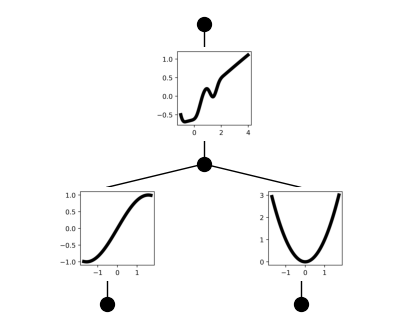

In [22]:
f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]] ** 3)
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=100)

config = KANConfig()
layer_widths = [2, 1, 1]
model = KAN(layer_widths, config)
model.set_symbolic(0, 0, 0, True, lambda x : torch.sin(x))
model.set_symbolic(0, 1, 0, True, lambda x : x ** 2)

results = train(
    model,
    dataset=dataset,
    steps=10000,
    batch_size=32,
    batch_size_test=8,
    lr=0.01,
    device=config.device,
)
model(dataset["train_input"])
plot(model)

## Applied Example: MNIST
Training a KAN on MNIST.

In [27]:
# Run these without ! in terminal, or run this cell if using colab.
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!mkdir data/
!tar -zxvf MNIST.tar.gz -C data/

--2024-07-02 00:12:46--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2024-07-02 00:12:47--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.2’

MNIST.tar.gz.2          [         <=>        ]  33.20M  4.15MB/s    in 17s     

2024-07-02 00:13:05 (1.94 MB/s) - ‘MNIST.tar.gz.2’ saved [34813078]

x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-ubyte.gz
x MNIST/raw/t10k-labels-idx1-ubyte
x MNIST/raw/t10k-images-idx3-ubyte.gz
x MNIST/raw/train-images-idx3-ubyte
x MNIST/raw/train-labels-idx1-ubyte.gz
x MNIST/raw/t10k-images-id

In [28]:
def split_torch_dataset(train_data, test_data):
    """
    Quick function for splitting dataset into format used
    in rest of notebook. Don't do this for your own code.
    """
    dataset = {}
    dataset['train_input'] = []
    dataset['train_label'] = []
    dataset['test_input'] = []
    dataset['test_label'] = []

    for (x,y) in train_data:
        dataset['train_input'].append(x.flatten()) 
        dataset['train_label'].append(y)

    dataset['train_input'] = torch.stack(dataset['train_input']).squeeze()
    dataset['train_label'] = torch.tensor(dataset['train_label'])
    dataset['train_label'] = F.one_hot(dataset['train_label'], num_classes=10).float()

    for (x,y) in test_data:
        dataset['test_input'].append(x.flatten()) 
        dataset['test_label'].append(y)

    dataset['test_input'] = torch.stack(dataset['test_input']).squeeze()
    dataset['test_label'] = torch.tensor(dataset['test_label'])
    dataset['test_label'] = F.one_hot(dataset['test_label'], num_classes=10).float()

    print('train input size', dataset['train_input'].shape)
    print('train label size', dataset['train_label'].shape)
    print('test input size', dataset['test_input'].shape)
    print('test label size', dataset['test_label'].shape)

    return dataset

train input size torch.Size([60000, 784])
train label size torch.Size([60000, 10])
test input size torch.Size([10000, 784])
test label size torch.Size([10000, 10])


train loss: 6.83e-01 | test loss: 8.60e+01 | reg: 2.81e+02 : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [20:50<00:00,  2.50s/it]


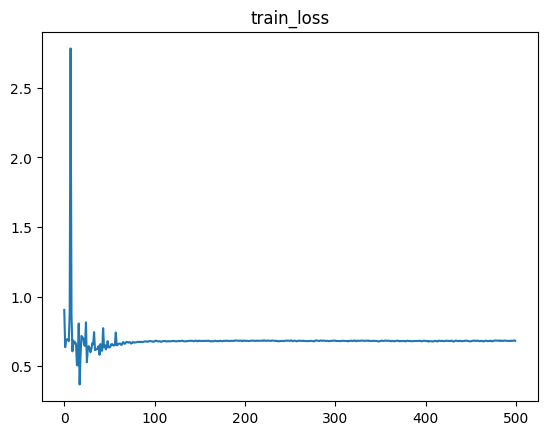

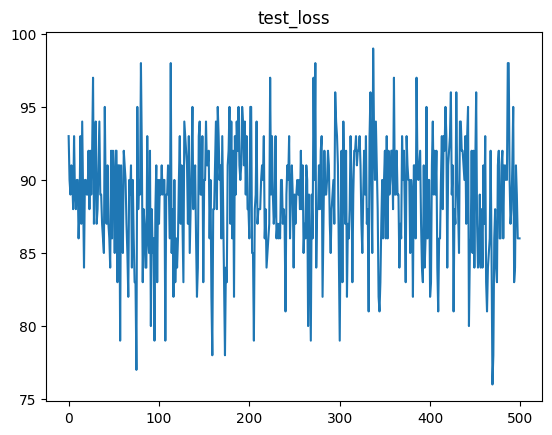

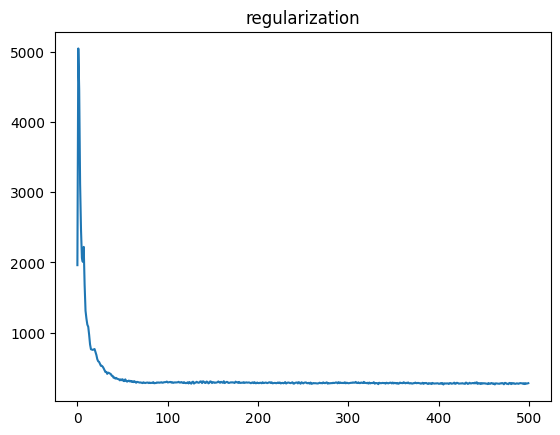

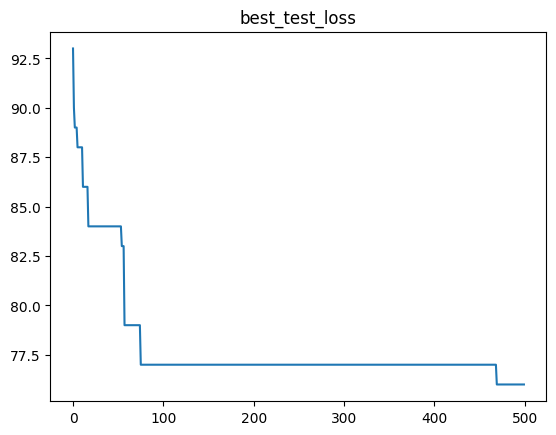

In [29]:
config = KANConfig()
config.grid_size = 10
layer_widths = [28 * 28, 64, 10]
model = KAN(layer_widths, config)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
train_data = datasets.MNIST("./data", train=True, download=False, transform=transform)
test_data = datasets.MNIST("./data", train=False, transform=transform)

dataset = split_torch_dataset(train_data, test_data)
loss = nn.BCEWithLogitsLoss()

results = train(
    model,
    dataset=dataset,
    steps=500,
    batch_size=128,
    batch_size_test=100,
    lr=0.1,
    log=1,
    device=config.device,
    loss_fn=lambda x, y: loss(x, y),
    loss_fn_eval=lambda x, y: (torch.argmax(x, dim=-1) != torch.argmax(y, dim=-1)).sum()
)
plot_results(results)

In [ ]:
# Evaluate predictions on test set
eval_preds = model(dataset["test_input"])

In [ ]:
correct = (torch.argmax(x, dim=-1) == torch.argmax(y, dim=-1)).sum()
accuracy = (correct / eval_preds.shape[0]) * 100
print(f"Final accuracy: {accuracy} %")